In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
### WARNING : in env\Lib\site-packages\torch_geometric_temporal\nn\attention\tsagcn.py :
### change 'from torch_geometric.utils.to_dense_adj' by 'from torch_geometric.utils'
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU

from gnn_model import StationFlowGCN
from train_gnn import(
    train_gnn_model,
    eval_gnn_model,
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader, create_degraded_networks
from utils.metrics import MAPE_loss


In [3]:
def create_numbat_dataframe(data_dir, year, weekdays, sheet_name):
    df_numbat = pd.DataFrame()
    for weekday in weekdays.keys():
        df_day = pd.read_excel(os.path.join(data_dir, f'NUMBAT {year}', f'NBT{str(year)[-2:]}{weekday}_outputs.xlsx'), sheet_name=sheet_name,skiprows=2, header=0)
        df_day['weekday'] = weekday
        df_day['weekday_idx'] = df_day['weekday'].apply(lambda x : weekdays[x])
        df_day = df_day.sort_values(by='weekday_idx')
        df_day = df_day.reset_index(drop=True)
        df_day = df_day.reset_index()
        df_numbat = pd.concat((df_numbat, df_day))
    
    rename_dict = {
        'Early     ' : 'Early',
        'AM Peak   ' : 'AM Peak',
        'Midday    ' : 'Midday',
        'PM Peak   ' : 'PM Peak',
        'Evening   ' : 'Evening',
        'Late      ' : 'Late'
    }
    df_numbat = df_numbat.rename(columns=rename_dict)
    return df_numbat


In [4]:
weekdays = {'MON':0,
 'TWT':1,
 'FRI':2,
 'SAT':3,
 'SUN':4}

data_dir = 'data/london/'

In [5]:
df_numbat_station_entries = create_numbat_dataframe(data_dir, 2023, weekdays,'Station_Entries')
df_numbat_station_exits = create_numbat_dataframe(data_dir, 2023, weekdays, 'Station_Exits')
df_numbat_link_loads = create_numbat_dataframe(data_dir, 2023, weekdays, 'Link_Loads')

In [6]:
nlc_idx = {
    nlc : i for i, nlc in df_numbat_station_entries[df_numbat_station_entries['weekday_idx'] == 0][['index','NLC']].values
}

df_numbat_station_entries['NLC_idx'] = df_numbat_station_entries['NLC'].apply(lambda x : nlc_idx[x])
df_numbat_station_exits['NLC_idx'] = df_numbat_station_exits['NLC'].apply(lambda x : nlc_idx[x])

df_numbat_link_loads['From NLC_idx'] = df_numbat_link_loads['From NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['To NLC_idx'] = df_numbat_link_loads['To NLC'].apply(lambda x : nlc_idx[x])

# df_numbat_link_loads['LineCode'] = df_numbat_link_loads['Line'].apply(lambda x : line_codes[x])
# df_numbat_link_loads['Link NLC_idx'] = df_numbat_link_loads['From NLC_idx'].astype(str) + '>' +  df_numbat_link_loads['To NLC_idx'].astype(str) + '@' + df_numbat_link_loads['LineCode']

In [ ]:
# df_numbat_link_loads = df_numbat_link_loads.sort_values(by=['weekday_idx', 'From NLC_idx', 'To NLC_idx'])
# df_numbat_station_entries = df_numbat_station_entries.sort_values(by=['weekday_idx', 'NLC_idx'])
# df_numbat_station_exits = df_numbat_station_exits.sort_values(by=['weekday_idx', 'NLC_idx'])

In [7]:
df_quarter = pd.read_excel(os.path.join(data_dir, 'NBT22_Definitions_Published.xlsm'), header=0, sheet_name='Qhr')
df_quarter['Time'] = df_quarter['Time'].replace('2345-2400', '2345-0000')
time_to_quarter = {
    time : {'qhr' : i, 'hour' : hour, 'tb' : tb} for i, (time, tb, hour) in enumerate(df_quarter[['Time', 'Timeband', 'Hour']].values)
}

In [8]:
ordered_qhr = {qhr : qhr_idx for qhr_idx, qhr in enumerate(df_numbat_station_entries.columns[12:-3])}

In [9]:
df_snap_station_entries = df_numbat_station_entries.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_entries = df_snap_station_entries.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_entries = df_snap_station_entries.reset_index()


df_snap_station_exits = df_numbat_station_exits.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_exits = df_snap_station_exits.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_exits = df_snap_station_exits.reset_index()


df_snap_link_loads = df_numbat_link_loads.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_link_loads = df_snap_link_loads.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_link_loads = df_snap_link_loads.reset_index()

In [10]:
station_entries = []
station_entries_features = []

station_exits = []
station_exits_features = []

link_loads = []
link_loads_features = []
lag = 4 
for i in range(len(df_snap_station_entries)-lag):
    
    station_entries.append(df_snap_station_entries.iloc[i+lag].to_numpy()[2:])
    station_exits.append(df_snap_station_exits.iloc[i+lag].to_numpy()[2:])
    link_loads.append(df_snap_link_loads.iloc[i+lag].to_numpy()[2:])

    entries_lag_features = df_snap_station_entries.iloc[i:i+lag].to_numpy().T[2:]
    exits_lag_features = df_snap_station_exits.iloc[i:i+lag].to_numpy().T[2:]
    loads_lag_features = df_snap_link_loads.iloc[i:i+lag].to_numpy().T[2:]

    entries_features = np.concatenate(
        (entries_lag_features, np.tile(df_snap_station_entries.iloc[i+lag].to_numpy()[:2], (len(entries_lag_features), 1))), axis=1)
    exits_features = np.concatenate(
        (exits_lag_features, np.tile(df_snap_station_exits.iloc[i+lag].to_numpy()[:2], (len(exits_lag_features), 1))), axis=1)
    loads_features = np.concatenate(
        (loads_lag_features, np.tile(df_snap_link_loads.iloc[i+lag].to_numpy()[:2], (len(loads_lag_features), 1))), axis=1)


    station_entries_features.append(entries_features)
    station_exits_features.append(exits_features)
    link_loads_features.append(loads_features)

In [11]:
edge_idx = [[], []]
for s,e in df_numbat_link_loads[df_numbat_link_loads['weekday'] == 'MON'][["From NLC", "To NLC"]].values:
    edge_idx[0].append(nlc_idx[s])
    edge_idx[1].append(nlc_idx[e])

edge_idx = np.array(edge_idx, dtype=int)
# edge_idx = torch.tensor(edge_idx, dtype=int)

In [12]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

print(numbat_2023_ent_ex_dataset.snapshot_count)

numbat_train_dataset, numbat_test_dataset = temporal_signal_split(numbat_2023_ent_ex_dataset, train_ratio=0.8)
numbat_train_dataset, numbat_dev_dataset = temporal_signal_split(numbat_train_dataset, train_ratio=0.9)

476


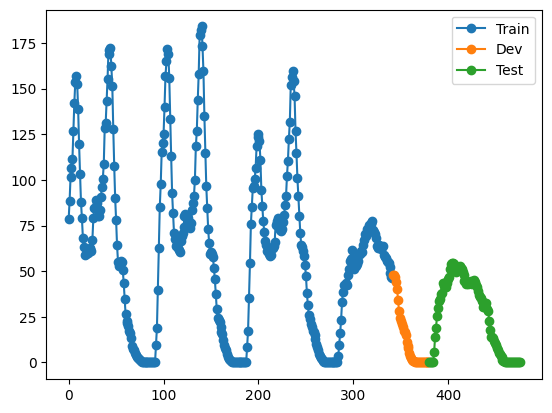

In [ ]:
idx = random.randint(0, numbat_train_dataset[0].x.shape[0] -1)

train_val = [snapshot.y[idx] for snapshot in numbat_train_dataset]
dev_val = [snapshot.y[idx] for snapshot in numbat_dev_dataset]
test_val = [snapshot.y[idx] for snapshot in numbat_test_dataset]

num_snap_train = numbat_train_dataset.snapshot_count
num_snap_dev = numbat_dev_dataset.snapshot_count
num_snap_test = numbat_test_dataset.snapshot_count

plt.plot(range(num_snap_train),train_val, label='Train', marker='o')
plt.plot(range(num_snap_train, num_snap_train+ num_snap_dev),dev_val, label='Dev', marker='o')
plt.plot(range(num_snap_train+ num_snap_dev, num_snap_train+ num_snap_dev+num_snap_test),test_val, label='Test', marker='o')
plt.legend()
plt.show()

In [14]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, num_date_features, num_lag_features):
        super(RecurrentGCN, self).__init__()

        self.num_date_features = num_date_features
        self.num_lag_features = num_lag_features
        self.hidden_dim = 32
        self.recurrent1 = DCRNN(self.num_date_features, self.hidden_dim, 1)
        self.station_entry_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.station_exit_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.link_load_head = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden_dim + self.num_lag_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),)

    def forward(self, x_entries, x_exits, x_loads, edge_index, edge_weight):
        
        h_date_station = self.recurrent1(x_entries[:,-self.num_date_features:], edge_index, edge_weight)
        h_date_station = F.relu(h_date_station)

        h_entries = torch.cat([x_entries[:, :-self.num_date_features], h_date_station], dim=1)
        h_exits = torch.cat([x_exits[:, :-self.num_date_features], h_date_station], dim=1)

        h_date_link = torch.cat([h_date_station[edge_index[0]], h_date_station[edge_index[1]]], dim=1)
        # h_date_link = torch.cat([h_date_station[edge_index[0].int(), h_date_station[edge_index[1].int()]]], dim=1)
        h_loads = torch.cat([x_loads[:, :-self.num_date_features], h_date_link], dim=1)

        station_entries = self.station_entry_head(h_entries)
        station_exits = self.station_exit_head(h_exits)
        link_loads = self.link_load_head(h_loads)
        
        return station_entries, station_exits, link_loads

Epoch 0


100%|██████████| 342/342 [00:03<00:00, 95.30it/s] 


Train Loss - Entries 63187.7734375; Exits: 64691.703125; Loads 334388.6875


100%|██████████| 38/38 [00:00<00:00, 94.56it/s]


Dev Loss - Entries 23302.703125; Exits: 15387.1748046875; Loads: 97840.4375


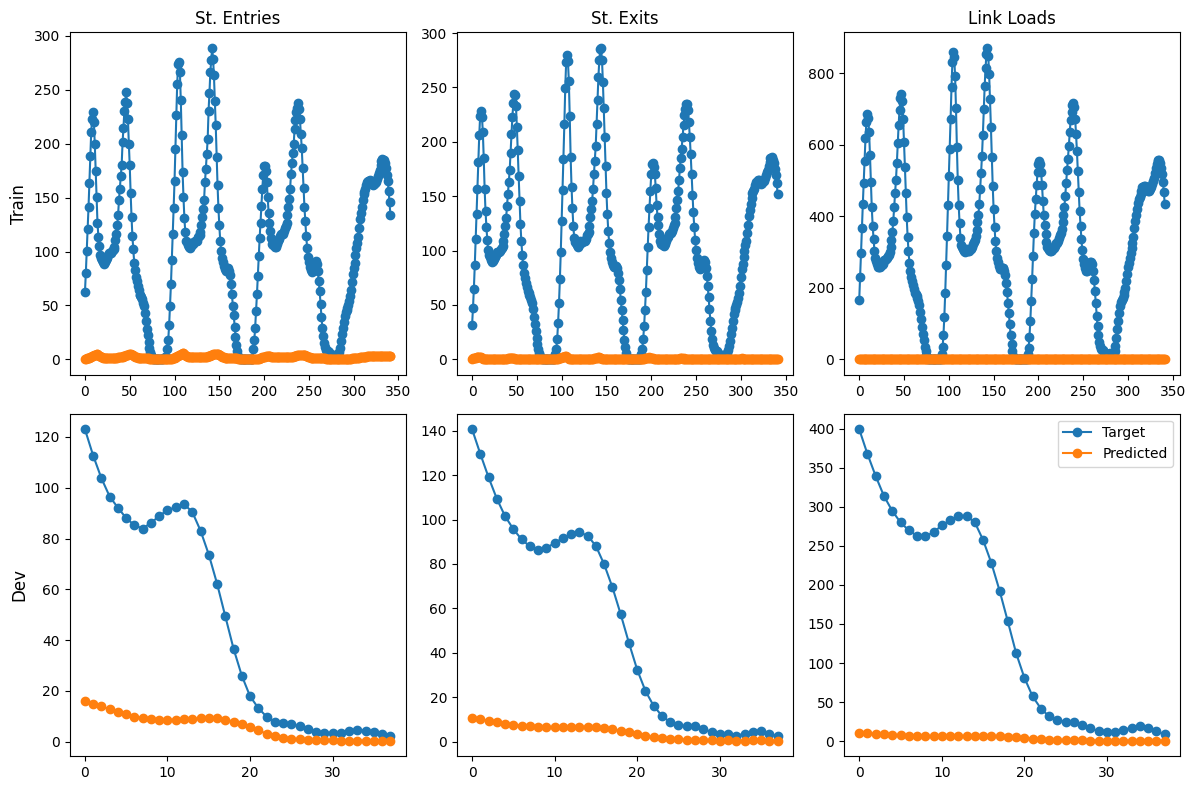

Epoch 1


100%|██████████| 342/342 [00:03<00:00, 107.28it/s]


Epoch 2


100%|██████████| 342/342 [00:03<00:00, 97.53it/s] 


Epoch 3


100%|██████████| 342/342 [00:03<00:00, 87.75it/s]


Epoch 4


100%|██████████| 342/342 [00:03<00:00, 87.28it/s]


Epoch 5


100%|██████████| 342/342 [00:03<00:00, 85.67it/s]


Epoch 6


100%|██████████| 342/342 [00:04<00:00, 75.50it/s]


Epoch 7


100%|██████████| 342/342 [00:04<00:00, 76.54it/s]


Epoch 8


100%|██████████| 342/342 [00:04<00:00, 83.51it/s]


Epoch 9


100%|██████████| 342/342 [00:04<00:00, 84.34it/s]


Epoch 10


100%|██████████| 342/342 [00:04<00:00, 83.51it/s]


Train Loss - Entries 59312.796875; Exits: 60395.5546875; Loads 268255.15625


100%|██████████| 38/38 [00:00<00:00, 79.53it/s]


Dev Loss - Entries 23244.125; Exits: 14479.3056640625; Loads: 82002.5859375


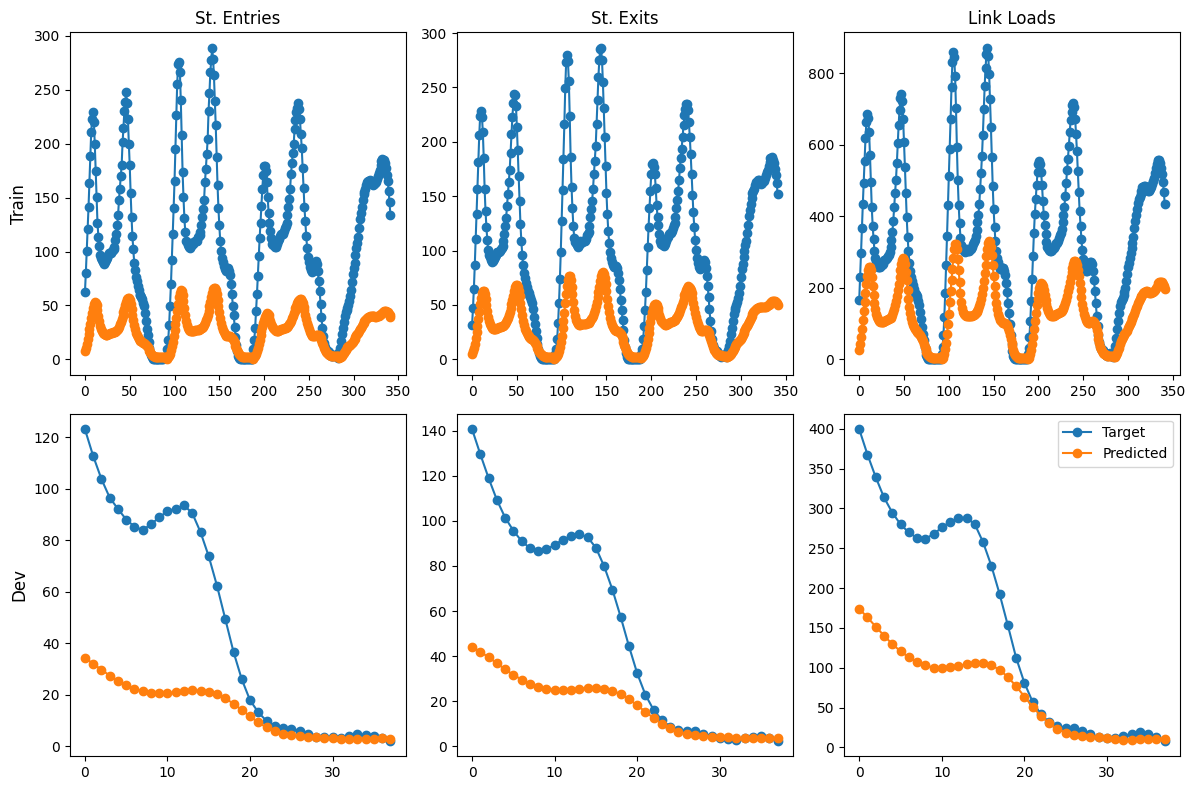

Epoch 11


100%|██████████| 342/342 [00:03<00:00, 87.91it/s]


Epoch 12


100%|██████████| 342/342 [00:03<00:00, 88.76it/s]


Epoch 13


100%|██████████| 342/342 [00:03<00:00, 88.53it/s] 


Epoch 14


100%|██████████| 342/342 [00:05<00:00, 63.91it/s]


Epoch 15


100%|██████████| 342/342 [00:04<00:00, 71.88it/s]


Epoch 16


100%|██████████| 342/342 [00:04<00:00, 73.24it/s]


Epoch 17


100%|██████████| 342/342 [00:04<00:00, 81.56it/s]


Epoch 18


100%|██████████| 342/342 [00:03<00:00, 86.86it/s]


Epoch 19


100%|██████████| 342/342 [00:05<00:00, 66.41it/s]


Epoch 20


100%|██████████| 342/342 [00:04<00:00, 68.90it/s]


Train Loss - Entries 58907.296875; Exits: 59872.58984375; Loads 264423.40625


100%|██████████| 38/38 [00:00<00:00, 66.75it/s]


Dev Loss - Entries 23510.208984375; Exits: 14253.8779296875; Loads: 80759.5859375


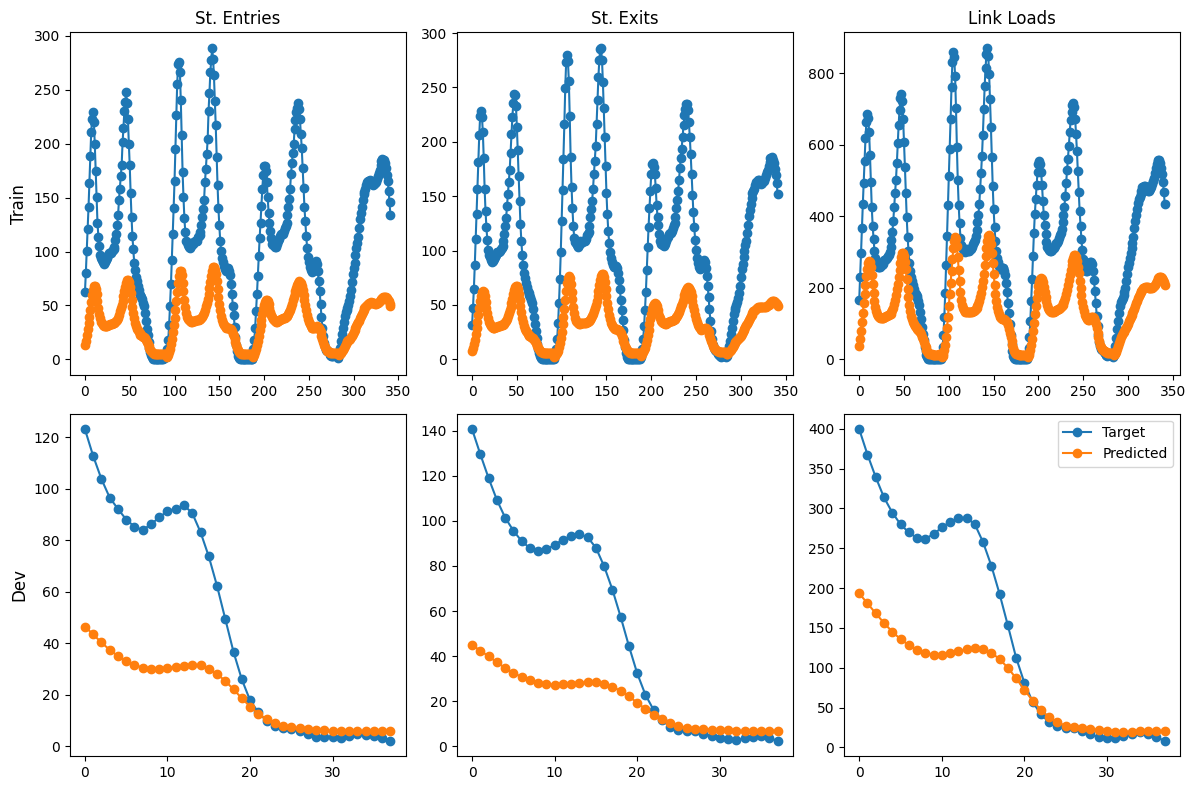

Epoch 21


100%|██████████| 342/342 [00:05<00:00, 66.58it/s]


Epoch 22


100%|██████████| 342/342 [00:04<00:00, 73.28it/s]


Epoch 23


100%|██████████| 342/342 [00:04<00:00, 70.59it/s]


Epoch 24


100%|██████████| 342/342 [00:04<00:00, 82.55it/s]


Epoch 25


100%|██████████| 342/342 [00:04<00:00, 82.82it/s]


Epoch 26


100%|██████████| 342/342 [00:04<00:00, 81.11it/s]


Epoch 27


100%|██████████| 342/342 [00:03<00:00, 85.81it/s]


Epoch 28


100%|██████████| 342/342 [00:04<00:00, 82.93it/s]


Epoch 29


100%|██████████| 342/342 [00:05<00:00, 67.65it/s]


Epoch 30


100%|██████████| 342/342 [00:04<00:00, 74.96it/s]


Train Loss - Entries 58139.1875; Exits: 58942.375; Loads 256119.4375


100%|██████████| 38/38 [00:00<00:00, 54.27it/s]


Dev Loss - Entries 23028.306640625; Exits: 13863.634765625; Loads: 78350.8203125


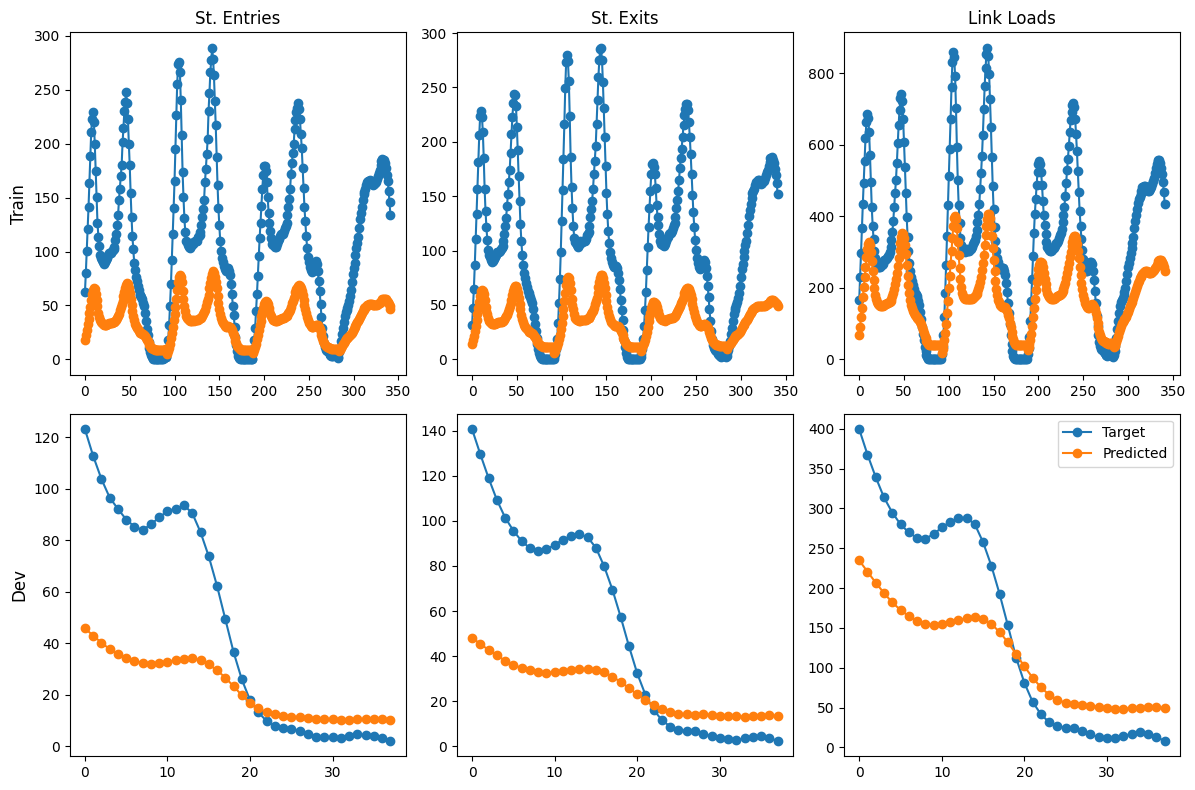

Epoch 31


100%|██████████| 342/342 [00:05<00:00, 63.14it/s]


Epoch 32


100%|██████████| 342/342 [00:04<00:00, 84.28it/s]


Epoch 33


100%|██████████| 342/342 [00:04<00:00, 81.40it/s]


Epoch 34


100%|██████████| 342/342 [00:04<00:00, 69.78it/s]


Epoch 35


100%|██████████| 342/342 [00:04<00:00, 83.51it/s]


Epoch 36


100%|██████████| 342/342 [00:04<00:00, 85.27it/s]


Epoch 37


100%|██████████| 342/342 [00:04<00:00, 83.39it/s]


Epoch 38


100%|██████████| 342/342 [00:03<00:00, 88.09it/s]


Epoch 39


100%|██████████| 342/342 [00:04<00:00, 85.15it/s]


Epoch 40


100%|██████████| 342/342 [00:03<00:00, 88.86it/s]


Train Loss - Entries 57044.62109375; Exits: 57427.5078125; Loads 233135.984375


100%|██████████| 38/38 [00:00<00:00, 79.06it/s]


Dev Loss - Entries 22426.150390625; Exits: 13314.9033203125; Loads: 74276.578125


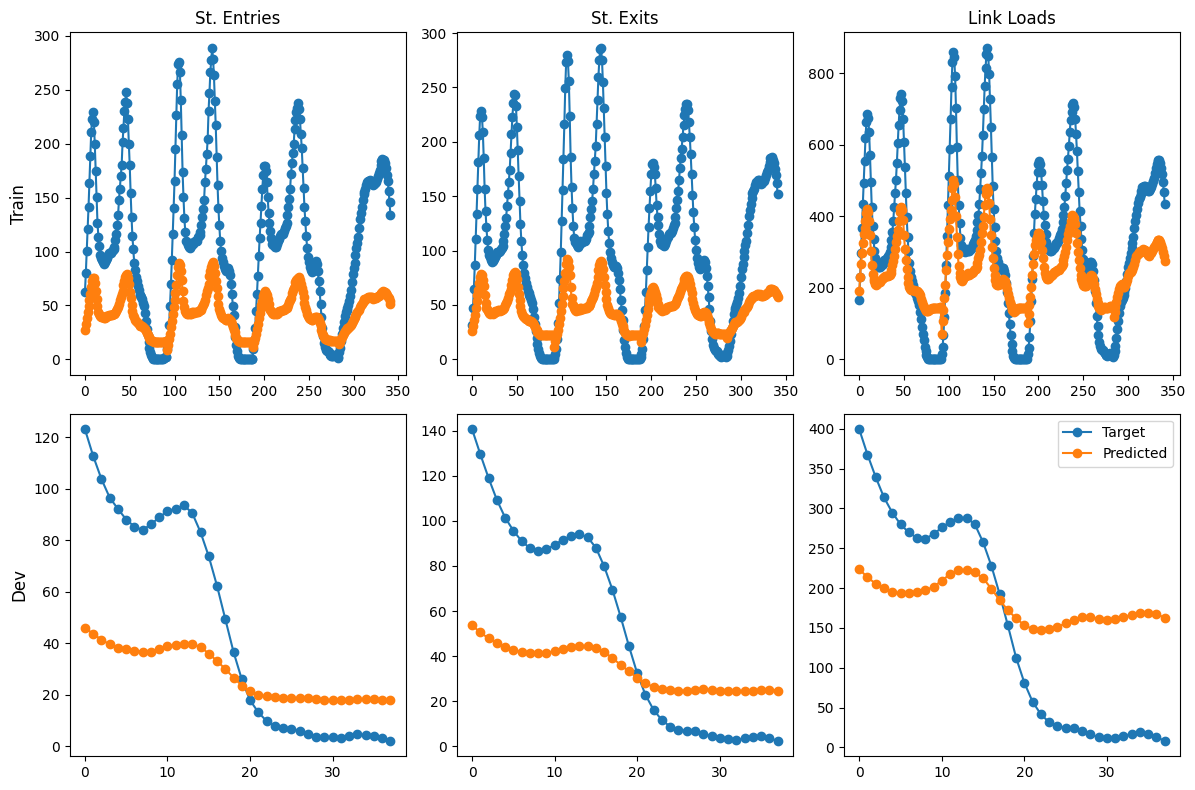

Epoch 41


100%|██████████| 342/342 [00:04<00:00, 81.83it/s]


Epoch 42


100%|██████████| 342/342 [00:03<00:00, 87.44it/s]


Epoch 43


100%|██████████| 342/342 [00:04<00:00, 78.60it/s]


Epoch 44


100%|██████████| 342/342 [00:04<00:00, 71.53it/s]


Epoch 45


100%|██████████| 342/342 [00:05<00:00, 67.83it/s]


Epoch 46


100%|██████████| 342/342 [00:04<00:00, 81.95it/s]


Epoch 47


100%|██████████| 342/342 [00:04<00:00, 72.69it/s]


Epoch 48


100%|██████████| 342/342 [00:04<00:00, 69.43it/s]


Epoch 49


100%|██████████| 342/342 [00:06<00:00, 55.83it/s]


Epoch 50


100%|██████████| 342/342 [00:07<00:00, 47.00it/s]


Train Loss - Entries 55306.94140625; Exits: 55630.80859375; Loads 226337.796875


100%|██████████| 38/38 [00:00<00:00, 57.80it/s]


Dev Loss - Entries 22020.974609375; Exits: 12969.0126953125; Loads: 96878.765625


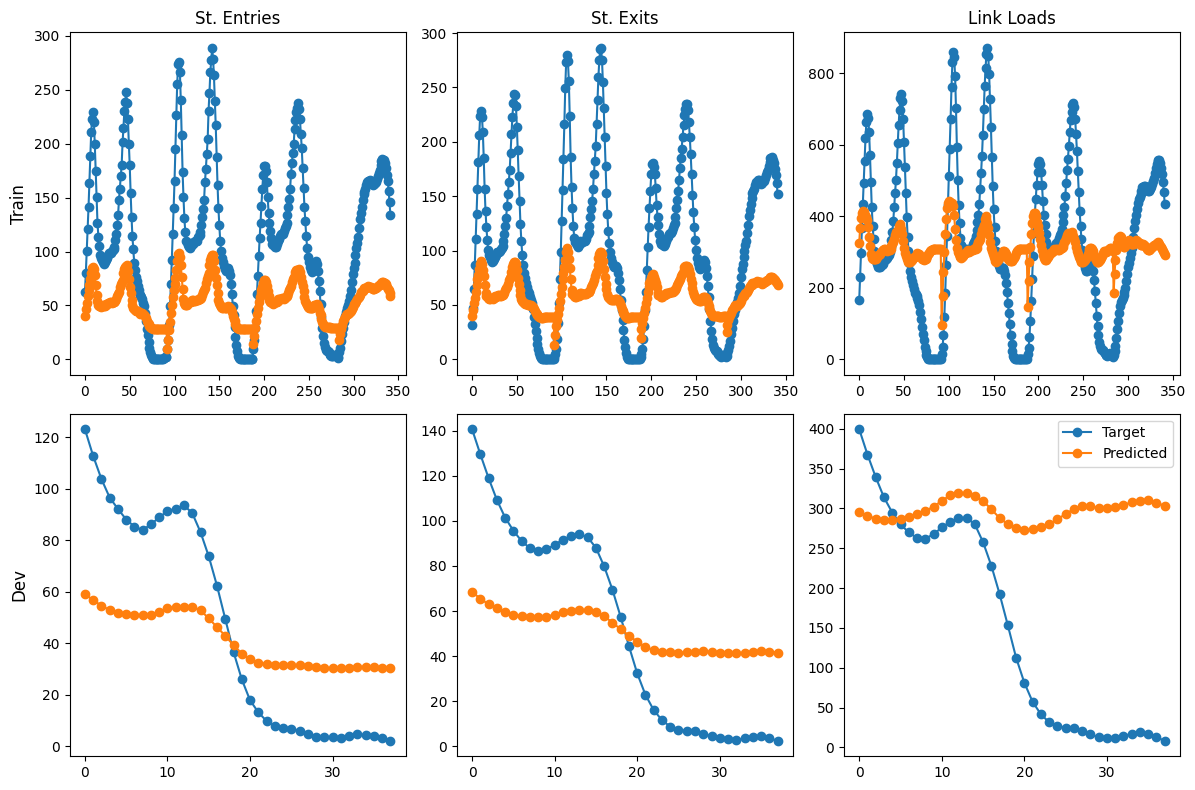

Epoch 51


100%|██████████| 342/342 [00:04<00:00, 70.99it/s]


Epoch 52


100%|██████████| 342/342 [00:05<00:00, 61.76it/s]


Epoch 53


100%|██████████| 342/342 [00:05<00:00, 67.35it/s]


Epoch 54


100%|██████████| 342/342 [00:04<00:00, 70.38it/s]


Epoch 55


100%|██████████| 342/342 [00:04<00:00, 75.84it/s]


Epoch 56


100%|██████████| 342/342 [00:04<00:00, 79.51it/s]


Epoch 57


100%|██████████| 342/342 [00:04<00:00, 72.16it/s]


Epoch 58


100%|██████████| 342/342 [00:05<00:00, 68.34it/s]


Epoch 59


100%|██████████| 342/342 [00:04<00:00, 71.50it/s]


Epoch 60


100%|██████████| 342/342 [00:05<00:00, 62.03it/s]


Train Loss - Entries 53511.00390625; Exits: 53881.328125; Loads 218593.453125


100%|██████████| 38/38 [00:00<00:00, 67.38it/s]


Dev Loss - Entries 21759.693359375; Exits: 13249.837890625; Loads: 87645.09375


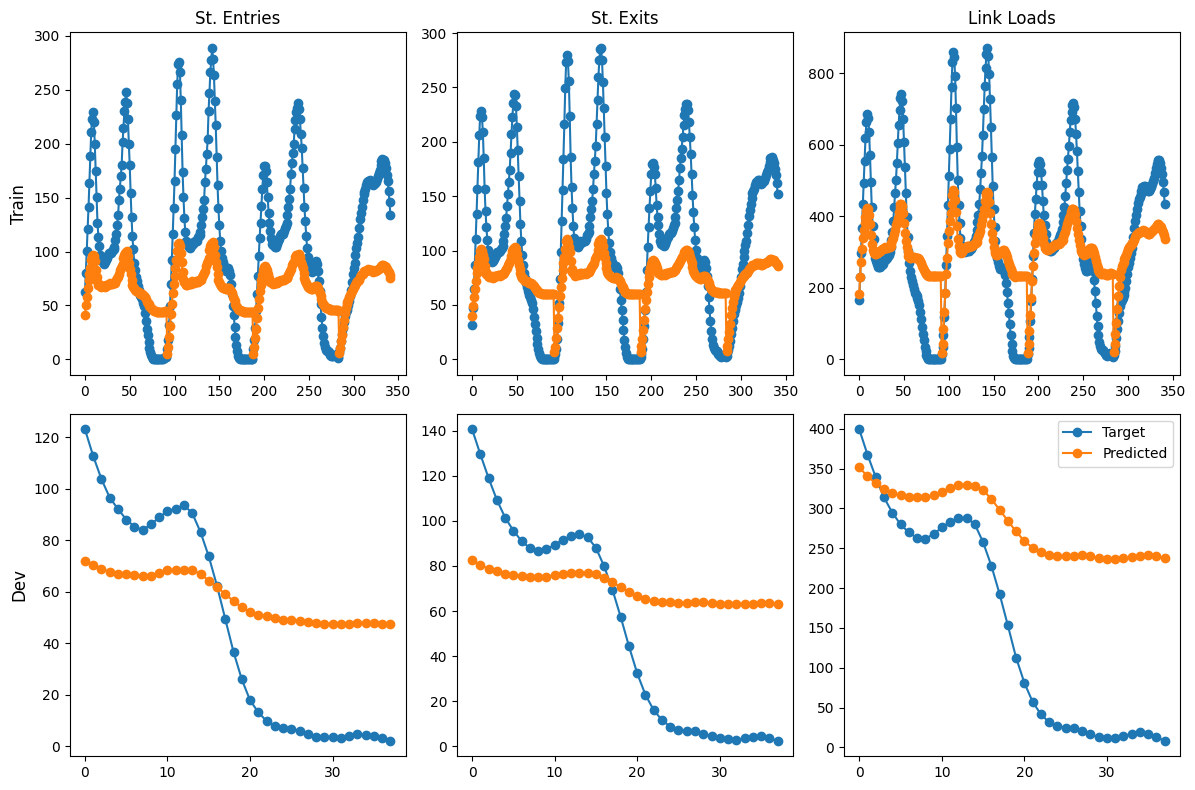

Epoch 61


100%|██████████| 342/342 [00:04<00:00, 78.29it/s]


Epoch 62


100%|██████████| 342/342 [00:04<00:00, 77.52it/s]


Epoch 63


100%|██████████| 342/342 [00:04<00:00, 74.53it/s]


Epoch 64


100%|██████████| 342/342 [00:04<00:00, 68.60it/s]


Epoch 65


100%|██████████| 342/342 [00:04<00:00, 75.53it/s]


Epoch 66


100%|██████████| 342/342 [00:05<00:00, 60.79it/s]


Epoch 67


100%|██████████| 342/342 [00:04<00:00, 79.92it/s]


Epoch 68


100%|██████████| 342/342 [00:04<00:00, 83.10it/s]


Epoch 69


100%|██████████| 342/342 [00:04<00:00, 79.35it/s]


Epoch 70


100%|██████████| 342/342 [00:08<00:00, 38.11it/s]


Train Loss - Entries 51805.22265625; Exits: 52803.75; Loads 216242.25


100%|██████████| 38/38 [00:00<00:00, 66.63it/s]


Dev Loss - Entries 22463.939453125; Exits: 14424.84375; Loads: 87765.171875


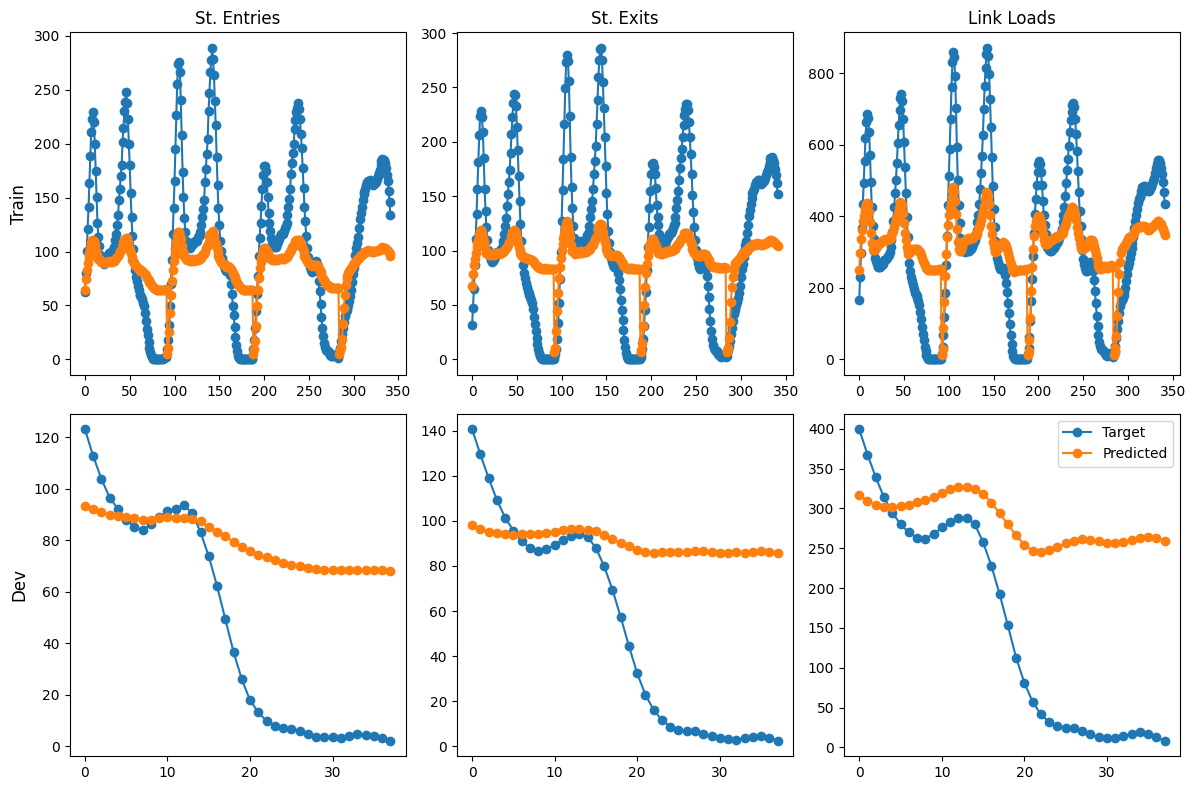

Epoch 71


100%|██████████| 342/342 [00:07<00:00, 47.12it/s]


Epoch 72


100%|██████████| 342/342 [00:04<00:00, 72.01it/s]


Epoch 73


100%|██████████| 342/342 [00:04<00:00, 69.64it/s]


Epoch 74


100%|██████████| 342/342 [00:04<00:00, 70.62it/s]


Epoch 75


100%|██████████| 342/342 [00:05<00:00, 63.99it/s]


Epoch 76


100%|██████████| 342/342 [00:04<00:00, 81.77it/s]


Epoch 77


100%|██████████| 342/342 [00:04<00:00, 72.79it/s]


Epoch 78


100%|██████████| 342/342 [00:04<00:00, 69.00it/s]


Epoch 79


100%|██████████| 342/342 [00:04<00:00, 73.20it/s]


Epoch 80


100%|██████████| 342/342 [00:04<00:00, 77.78it/s]


Train Loss - Entries 51108.71484375; Exits: 52485.36328125; Loads 213878.71875


100%|██████████| 38/38 [00:00<00:00, 69.02it/s]


Dev Loss - Entries 23822.72265625; Exits: 15951.845703125; Loads: 84592.8046875


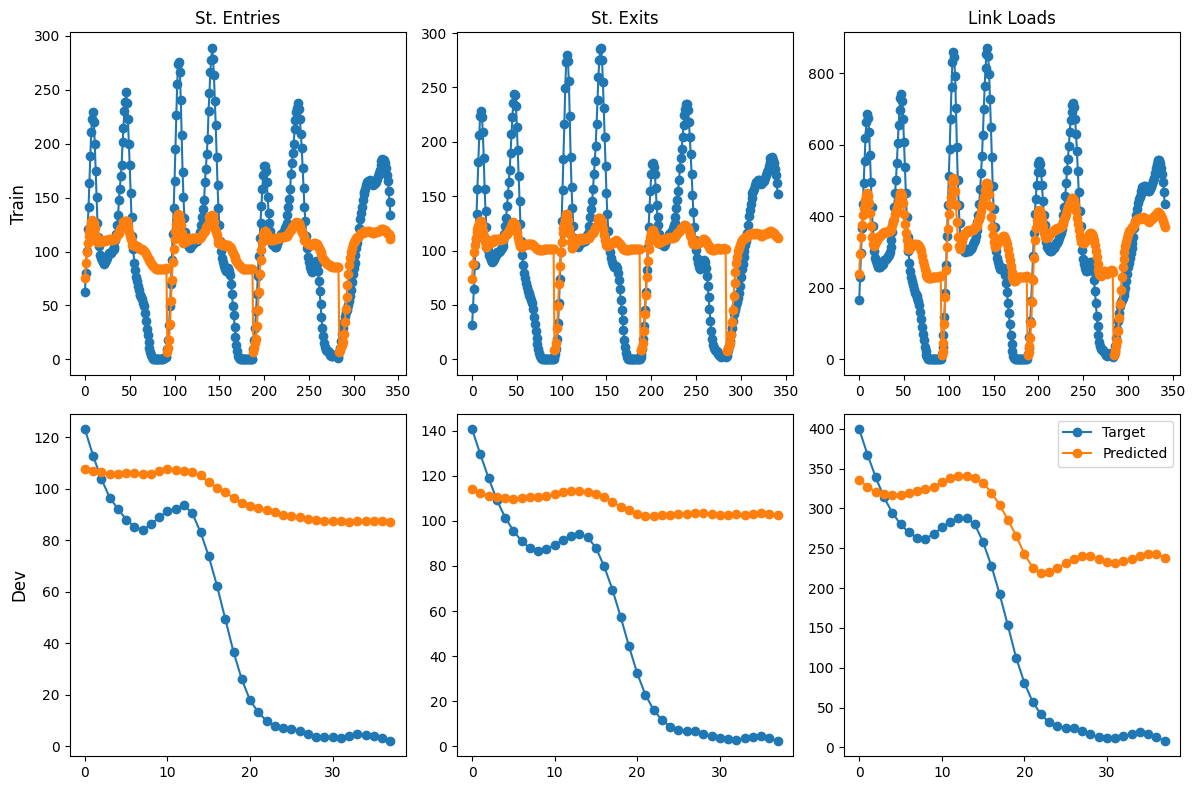

Epoch 81


100%|██████████| 342/342 [00:04<00:00, 71.48it/s]


Epoch 82


100%|██████████| 342/342 [00:04<00:00, 70.10it/s]


Epoch 83


100%|██████████| 342/342 [00:04<00:00, 75.15it/s]


Epoch 84


100%|██████████| 342/342 [00:04<00:00, 76.42it/s]


Epoch 85


100%|██████████| 342/342 [00:05<00:00, 65.23it/s]


Epoch 86


100%|██████████| 342/342 [00:04<00:00, 69.78it/s]


Epoch 87


100%|██████████| 342/342 [00:04<00:00, 71.28it/s]


Epoch 88


100%|██████████| 342/342 [00:04<00:00, 70.58it/s]


Epoch 89


100%|██████████| 342/342 [00:05<00:00, 63.82it/s]


Epoch 90


100%|██████████| 342/342 [00:04<00:00, 69.64it/s]


Train Loss - Entries 51074.5859375; Exits: 52500.87109375; Loads 210643.234375


100%|██████████| 38/38 [00:00<00:00, 53.53it/s]


Dev Loss - Entries 24742.953125; Exits: 16621.921875; Loads: 79122.59375


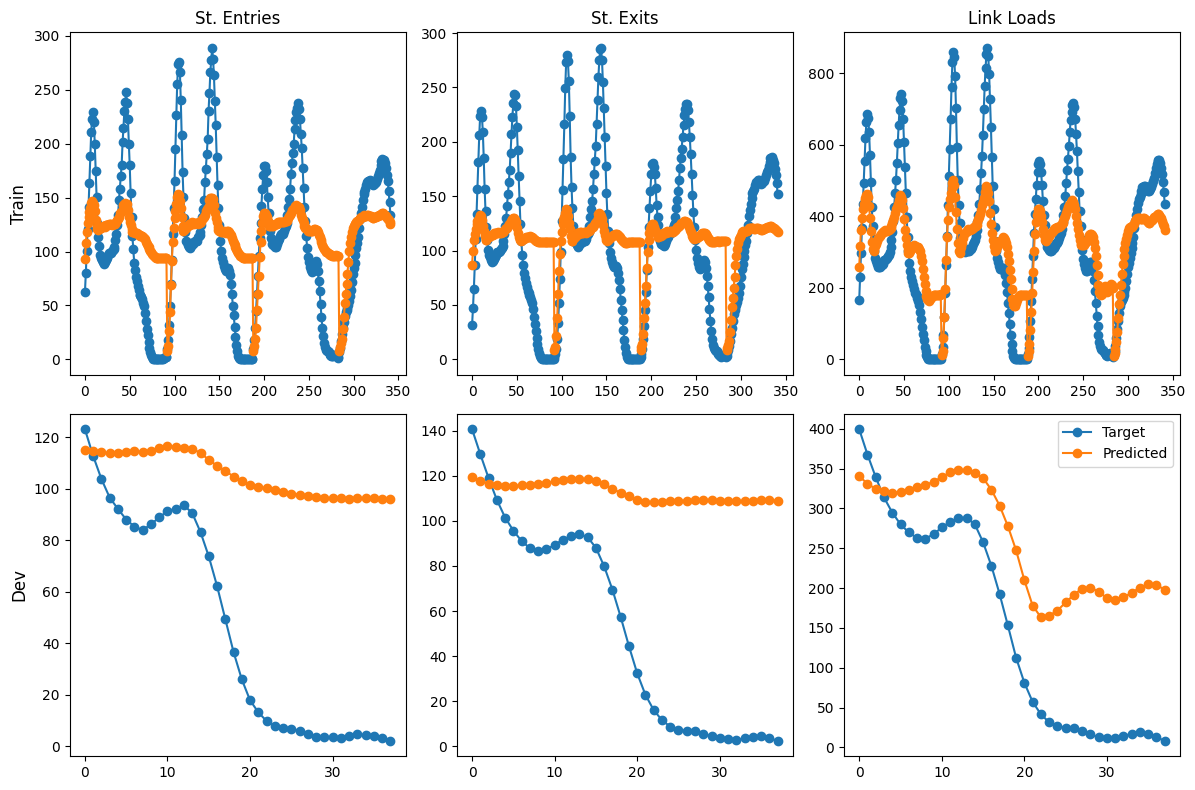

Epoch 91


100%|██████████| 342/342 [00:05<00:00, 63.72it/s]


Epoch 92


100%|██████████| 342/342 [00:05<00:00, 66.59it/s]


Epoch 93


100%|██████████| 342/342 [00:05<00:00, 59.03it/s]


Epoch 94


100%|██████████| 342/342 [00:05<00:00, 65.06it/s]


Epoch 95


100%|██████████| 342/342 [00:05<00:00, 65.83it/s]


Epoch 96


100%|██████████| 342/342 [00:05<00:00, 65.68it/s]


Epoch 97


100%|██████████| 342/342 [00:04<00:00, 68.57it/s]


Epoch 98


100%|██████████| 342/342 [00:04<00:00, 68.67it/s]


Epoch 99


100%|██████████| 342/342 [00:05<00:00, 64.41it/s]


In [32]:
model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion =torch.nn.MSELoss()
# criterion =torch.nn.L1Loss()
epochs = 100

num_stations = numbat_dev_dataset[0].x.shape[0]
num_links = numbat_dev_dataset[0].edge_index.shape[1]

for epoch in range(epochs):
    ### TRAIN

    model.train()
    print("Epoch", epoch)

    entries_train_loss = 0
    exits_train_loss = 0
    loads_train_loss = 0

    entries_pred_plot = np.empty((num_snap_train, num_stations))
    entries_true_plot = np.empty((num_snap_train, num_stations))

    exits_pred_plot = np.empty((num_snap_train, num_stations))
    exits_true_plot = np.empty((num_snap_train, num_stations))

    loads_pred_plot = np.empty((num_snap_train, num_links))
    loads_true_plot = np.empty((num_snap_train, num_links))

    for time, snapshot in tqdm(enumerate(numbat_train_dataset), total=num_snap_train):
        pred_entries, pred_exits, pred_loads = model(
            snapshot.x, 
            snapshot.features_exits, 
            snapshot.features_loads, 
            snapshot.edge_index, snapshot.edge_attr)
        entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
        exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
        loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
        entries_true_plot[time] = snapshot.y.numpy()

        exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
        exits_true_plot[time] = snapshot.targets_exits.numpy()

        loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
        loads_true_plot[time] = snapshot.targets_loads.numpy()
    
    entries_train_loss = entries_train_loss / num_snap_train
    exits_train_loss = exits_train_loss / num_snap_train
    loads_train_loss = loads_train_loss / num_snap_train
    
    train_loss = entries_train_loss + exits_train_loss + loads_train_loss
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%10 == 0:
        # print("Train Loss:", train_loss.item())
        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))
        
        fig, axs = plt.subplots(2, 3, sharex='row', figsize=(12, 8))

        for ax, col in zip(axs[0], ('St. Entries', 'St. Exits', 'Link Loads')):
            ax.set_title(col)

        for ax, row in zip(axs[:,0], ('Train', 'Dev')):
            ax.set_ylabel(row, size='large')
        axs[0,0].plot(range(num_snap_train),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[0,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[0,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[0,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

    ### EVAL
        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        entries_pred_plot = np.empty((num_snap_dev, num_stations))
        entries_true_plot = np.empty((num_snap_dev, num_stations))

        exits_pred_plot = np.empty((num_snap_dev, num_stations))
        exits_true_plot = np.empty((num_snap_dev, num_stations))

        loads_pred_plot = np.empty((num_snap_dev, num_links))
        loads_true_plot = np.empty((num_snap_dev, num_links))
        for time, snapshot in tqdm(enumerate(numbat_dev_dataset), total=num_snap_dev):
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)
        
            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev
        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))
        axs[1,0].plot(range(num_snap_dev),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[1,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[1,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[1,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

        fig.tight_layout()
        plt.legend()
        plt.show()

In [23]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 107.17it/s]

MSE Entries: 22153.2754
